<a href="_index.ipynb">&larr; LAB </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>

<b>Name, Vorname:</b> 
# LAB 2: Filterung und DFT als Näherung für spektrale Analyse

### Inhalt
[0. Allgemeines](#allgemeines)

[1. FIR und IIR Filter](#filter)

[2. Schätzung der Fourierreihe durch FFT](#fourierreihe)

[3. Schätzung des Fourierspektrums von Sinustönen mit überlagertem Rauschen durch FFT](#fourier_sine_noise)

[4. Fourierspektrum eines Rechteckpulses](#fourierspektrum)

## 0. Allgemeine Hinweise<a id='allgemeines'></a>

* \<SHIFT\>-\<RETURN\> führt eine Codezelle aus und rendert eine Textzelle.
* In Markdown sind Leerzeilen wichtig zum Trennen von Abschnitten! 
* Sie können LaTeX-Code zwischen \\$ ... \\$ einschließen.
* Kontexthilfe zu Funktionen etc. bekommen Sie über \<SHIFT\>-\<TAB\>

Nach dem Praktikumsversuch exportieren Sie das Notebook mit Textantworten, Codezellen und Plots als HTML (File -> Export Notebook As ... -> Export Notebook to HTML) und reichen es in Moodle ein.</div><br />

***

In [ ]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp
dsp.versions() # print versions 
    
%matplotlib inline
import matplotlib.pyplot as plt
size = {"figsize":(12,5)} # Plotgröße in Inch

import numpy as np
import scipy.signal as sig
import wave

from IPython.display import Audio, display
#-----------------------------------------------------------------------------
def wav2np(filename):
    """ Read the wav-file and convert it to a one or two-dimensional numpy array,
        depending on the number of channels. 
        Properties of the WAV-file are stored as function attributes (evil)
    """
    wf = wave.open(filename,'rb')
    wav2np.N_CH = wf.getnchannels() # number of channels
    wav2np.W    = wf.getsampwidth() # wordlength per sample in bytes
    wav2np.N_FR = wf.getnframes()   # number of frames
    wav2np.f_S  = wf.getframerate() # sample (frame) rate 
    
    print("{0} channels with {1} frames of {2} bytes and f_S = {3} Hz.".format(wav2np.N_CH, wav2np.N_FR, wav2np.W, wav2np.f_S))
    
    if wav2np.W == 2:
        samples_in = np.frombuffer(wf.readframes(-1), dtype=np.int16) # read wav data as 16 bit integers, R and L samples are interleaved
    elif wav2np.W == 1:
        samples_in = np.frombuffer(wf.readframes(-1), dtype=np.int8) # read wav data as 8 bit integers, R and L samples are interleaved
    else:
         raise TypeError("Unknown data format: {0} bytes".format(wav2np.W))   

    samples = np.array([samples_in[idx::wav2np.N_CH] for idx in range(wav2np.N_CH)], dtype=np.int32) # deinterleave channels to numpy array N_CHAN x N_FRAMES
    return samples


## 1. FIR und IIR Filter<a id='filter'></a>

In diesem Abschnitt analysieren Sie die beiden Filter aus der folgenden Abbildung:

<table><tr><td>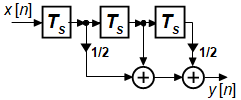</td><td>&nbsp;&nbsp;</td>

<td>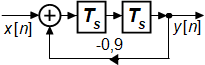</td></tr>

<tr><td>Filter 1</td><td>&nbsp;&nbsp;</td><td>Filter 2</td></tr></table>

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Woran erkennen Sie, welches davon ein IIR- und welches ein FIR Filter ist?

* Berechnen Sie die Differenzengleichung der beiden Filter.

* Berechnen Sie die Systemantwort der beiden Filter. Können Sie die Impulsantwort beider Filter einfach aufschreiben?

* Berechnen Sie Pole und Nullstellen beider Systemfunktionen und skizzieren Sie (auf einem Blatt Papier) den P/N - Plan.

* Schätzen Sie aus dem P/N Plan ab, um welchen Filtertyp es sich handelt. Bei welcher Frequenz liegt das Maximum des Betragsgangs? Welchen Wert hat es?
***

### 1.1 Simulation

Für die Simulation müssen wir zuerst die Filter als Koeffizientenvektoren `a` und `b` darstellen (siehe folgendes Bild und Abschnitt 3 von LAB 1).

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAU4AAACSCAMAAAAdBtO7AAAACXBIWXMAAC7hAAAu5wGLE5KDAAABm1BMVEUAAAAAADoAAGYAOjoAOmYAOpAAZpAAZrYBAQECAgIDAwMEBAQFBQUGBgYHBwcICAgJCQkLCwsNDQ0QEBASEhITExMUFBQYGBgZGRkgICAkJCQmJiYoKCgwMDA2NjY3Nzc4ODg6AAA6ADo6AGY6OmY6ZpA6kLY6kNs9PT0/Pz9AQEBGRkZHR0dISEhPT09QUFBSUlJTU1NXV1dYWFhZWVldXV1fX19gYGBjY2NmAABmAGZmOgBmOjpmOpBmZmZmkLZmkNtmtttmtv9nZ2doaGhtbW1vb29wcHBxcXFycnJ3d3d4eHh/f3+Dg4OHh4eMjIyNjY2Pj4+QOgCQOmaQZgCQZjqQkJCQttuQtv+Q27aQ2/+VlZWXl5eampqbm5ufn5+jo6Onp6eoqKivr6+1tbW2ZgC2Zjq2kDq2tma2tv+227a22/+2/7a2//+3t7e8kDq/v7/Dw8PHx8fPz8/R0dHX19fbkDrbkGbbtmbbtpDb25Db29vb/7bb///f39/g4ODn5+fv7+/39/f/tmb/25D/27b//7b//9v///+HkaCvAAAPWElEQVR42u2d/WPbRhnHL+26NG1abRgmDDZzeAsTGMPMcMMGo8EQmDWDy9soZsZ10wJjQbVjDxhVJTlL9Geje9GL9ZZ7k11vvh+StLa+evTRc8/dPXc6AXdTJBawQbDBuTY4z/bAtafk74t7YOv+BpEYzsPIv+Y0OC0jr5jUpuTrMAgVpLcknAOQV3RqU/J1GIQK0qPHOYMV/PjKhz7O+ZV/vAle+IAWp6ZnlQYTzmwdJqGC9Ohxnh8cujOEDuOcbX3j6cXvtmlx6lyfMX13wINTrh5DZT++9t+9/aCyX9xD3nrt6QYnH06vQd8OYyd0Vo/pxjt5cV7cg4HTx4konnnuusHJh3Pm9zARTtQyQZQMOOdhmxl0XPlwpioJ4JSlR49zDvaPw8oOqzlmyoBzFhq9LeadqUoCOGXpUeM8PwjCJMQZhE4WnMeh0ftiOFOVBHDK0qPFiQLnxb2gZUcQEVPG2HmcGJTyxs6EkmDslKG3tFGRHozxI2FTBGdSSQynFL1l4wx6W8I4k0piOKXoyc0oWYlj7Zhl84WwmWm1dfnlJ5VShGx6nFR6ReDM+aY2iv1Pq9yzo5bNkvm8FKvHoDXBfz3sZX13RhOEFd+g096zhQ+mTYNHb8k4ASj3Ib4nNwB4F+EEoHRkBpZ5zkzGArlWG54QBPHw9s7NnXdTv5uilCKEDHJc943rN3f+GjtDdcCut3ScGN8t7/fuQ4zTK413iGXnB4mWKAsnAJXB9Ze9XzvP0r6bopSOEwBV//XNmA4+g9r9M6OedJwtwFd0P+zuM+YcM1KQKUrZQjvXZepVl+qdsJrCX7t3AvrlH4Sjj0OX1jtBA0Avv36a9t0UpSzvBNXv7cZ0/DMARj1GHuI4ldbU++PVXbDzeZvg9PCGow8/3j8C4Op7eTiVtun2buxcv34nfziQK4RuitfovHoD7LyRuGGq/oeU4UUguHqcqk66OHfAd1AnpaWgNppYFsb7+ZX77mP8dypOtYsOt3vgNGs4gI/OF0I3BZb3wcP4DasMnBS9iODKcRqJg6ZWuuPMwN2cOuUMM06e/G6+0ImdcRHJjlJScOU4Mw9KWOZF/qt3aRrQy3DSCgHalGYouEY43U/e8mO/GE5aIWqcoeA64YRusC0DJ6UQPc5AcH1wzrcO3bMDCd5JLUSLMyK4PjgvHu+BrZ9KiJ3UQrQ4I4LrVdnpxnL0OvIq+/q17BucG5wbnJ9WnK3MVX8dJpzZOvlCWTg59JaCc3EGKYGBct1fTIVNJ08oC+flepeYVBDO2BTc4kETPa8YmSpsOnlC6RdBo3eJSQXhnC0msznPOYunxHltjwvxM5BmEtPhxy8+Alt3Rc8ZU+G3PS7Ez0CaSSyHnx94p8TLadth8BkzniqiImZ7QoibgTSTmA6HaxO9U8P5Flv1abZZTxVRcQ0NFgB/dFwBIase6DQcV0TJdbswogIUV51CcaKATRYxDQlN1WY9VVTFrfl3RZm4IkKdoLL0Oa5+wSQ9kDoq1jtRwPZvYh2fcsgX9n2ViUJMZ3fOBSGnTHRq3C2Rb5JT8T3FKRYnWvt59tX7F/fAtmshEA2OsE9UvKs4DNyq7HAL/ekATgGdcDt5/MKCGdBRsbETLv/ETx7su8eHbg9ab3GEfaLiHsOEOHGrE5db6F+H7szzqyavky9e2KP7wTqMgpuis72rf3T/7YWZj+673ondKgA9nrBPVM7/Dr0T+0LLFRDyYp8nZMHGscJVPyNKF7/9kEgpZsE451f++SZ4wTvpI4xzwrVWIlDBlR35gmoJCZ3/+CkZTBpcFx9ROtj2x6XdpaVAiHe6YOIKFYzT84WBkMz5j/Dsucbl5HG0+7idrTpLw4ljp/hT2zN//kdI5exrZFXcFFjiBmGcJvPgRAAnbgCl4RTUOQ6eHRB+KD9c7L36fOeST16gzgbnBucG5wbnBudnCmdf07RbmtYU1RljHU3C1h4SpNjJkIRnV9R20VwYKU5Jxpp2LIUvrbJU7zzCHCaixlflyBB7ejJqeldYih2niR85ELZ9KJq9IcUSTFFGpWDuseQsFafbEMwJRqvWiQQIDd78XLK0RcMPB86JpFDVlSMDo7BiycEJL81aMk7OfGda1RpIgVCVkVHCpS4YfnhwjiSFqrYcGS8KT2ThHC0zo4SLbbzyuiFuuWP85leGLa5jG3/5uSELp/nLnjFZIk67T+b7agMR13IGZGa40hciKskcwrJD+tTNkyXh7HtdiWpT1+veVZT4W3fD63tX6rre9KAqAnFYkjn4DsM5PK2tdzQPamW6BJyO15FokxONm/zdEx2AOolRptcLb3I6qNOSYw42pArULmnVhzXem8OEswXUSKQeKJx9NB0okSUbY5V3TNAAqiHBHBw1ykCzF264UTTOPlAXsgPTEldv/iS2xsCu8D2q3wXlhT7iVBUYXMR7SPFrlY9zqpA7NvGXro54+s92iXQ3AxlPmKM1nQBlHDenxNsH74GyvSjW4lqmw4DzyHeicJl+m8Oven6nO5TpAY48XctPaoU6Le7hRdnvbwZiTpnnHtPjdEq+K4b2W0Cld0ryOHzFNzOUCaVpxkBojwLXVvxcRagzoTcHn7dn+fGn7rLfY7s+5Mc5CoZykYdI6tSjCJNs1jAJGp6ITJthOWHZ6xacwKFQW8QcYpPSMvH5h27KPUa/T187zb4ktFUOF85eUJMi9h9RD7txXq9ujIL2NyIzYOjklPFGN3pw5oXbMmTDSfa/0ICZFKvAbMgTuHGLYmcfXupYXDjbqN2cGIbxDvghfDRnihh3mHAC8EV0V6ahzARVtiYbTu8SUbsYMcdEjX2XGSfcdElFGIxQzHaDhayXl5bFgbOF7NciKi7rxj64DNyFLYZg3Td4thuaLJqjo+4NV1FvlxCLsMBLbcKfjRvwn09yPYQLJ65dA13XvwtegwvIR+g/eyyeUBuS2jQKZQZuNBDSeWe5Zx+hyhIxBxLosC3pNslw360C6I56KAZdvQa8+vdwB24r9Ex+ZR8G9ToSX1rU+XQTRyl3HNTriAxLJS2jHdHSQ3mLLb0PeTTHaHw1SYqVAWxmvrWLN42S3RRNg9x55JQqdQ/H0XG0txU10cHxHIEeQx/3s8dBNzvSGKtswwoL7gGHb2fSVfxVrA/AgyI6Sl6cMuKnHHEkr1t+kxy1nGMytprsv/Z5c+lWyj1u+u7PMg5n+O7QXzJ9og2CvAF7ZnDsrzkOZLwbxTGa6YFa0hzeXHrD774FYkYwpVkQTqcWn5NpBIMJNtO1eCPHs7TdqcQzSE3+iZ6pEkufWGpwiwvCCU8RvQDnyM8bMHNoRvF1FYUrWWuWFhowXnOC9Em0ok0j03npiNK34WXKdxolUAuufFwBKt+0ylQFlSCbaNaBMuRDcCLHnCDD2QnuxqDkR5IcnGmbRLNNbphVb5w4MsypMax5HXDedJhdh0MRY2oao4Y3YOSmMJVjDvHPEii1vfHQ2OiVFxYvFIfTdbr+Q3ug0hewfVAJRiS6wNyb01WlmINjWdt/sBHlWFJxoqcO0RsK0l/sxD4xPOx8CWh1XXQ5jKFrX35F6wxFIQw72ldufVuXsTrHtfttTdOaXTOzeZnD3SrJG17SXuzEMc/uqEDOGpYqmErROQJ9t8ASRQQfKcWvJEl/sRMHzpGkFVYjCas78ThLzlonGpzw1RnIQzNe7AR4nErOoppGZiKRtT8vZyUeDc6Le/uRl5MkX+zEjnPM+yx+rExkrXJV5awTpeuaH+9j58x4sRPgcSopKwlRylOVEjO8Ml0SztmLZG+G9Bc7MeMkOVPh2oV3GZCw7LYmZ409Jc45iLzFLfliJ2acZGm8cO3qCOw5kYgZkqIwBc6zvf2wG598sRMzzqlh3AKGIbyiEs4WeTpjUR0b6xjOkiq7//IOKaMiXE8/xY9pXaL+ycGhKxun+1nFeX7g7x0sJaP0WcdZkCUbnBucG5wbnBucG5yrxelIMt/a4IRFl/SUWQPIGRn2gbHGOKeK+EgblhHHlqqpTl7i3ILu+cCpycl3ogewxxIut7m4C/qa4URLOkvis0UoNVUVdyu0gacyXVOcFp6KFd4SZSJnSxF/H1BtTXG2xLdgRaVK8pRTGU5O1jSvB86P9sK91YNl1zyzbxGhXnQtt4DOJLDHWhOcxy984P6HZPeC7ZZ5phMiQpaysFSeW8d3cs6NaleAk0wo45y+jV6nAtBPVrOiQmaoMxHREbFnVZX94uOP/7aQe148yDLyipkjVIwOnZ5hrso7t77+k98vvDmF7wU7SaFidOj06LuqknCe7QFw7SmuVbMrH/pby6Zg0DLfYtNAViOl//lC5wf+5KqYzmW71ObpEcHleyfaNx8ubSJ7q6dhoHo5WSA0w/u9C+vg/efzcPK+7KxAnOcH33x68Qg5JtpbnRtDRAjt9y6sQ/afXy+csIZtvQ1fRkD2VufFEAqR/d7FddYRZ6TM9/NwzsMwH0yZplrt7/cuqkOJM01v9TiDvdWzMMxCs7fzrA72exfUocWZprd6nOHe6hkYjkOz9/OsztrvnVWHFmea3nNR2d1LY+cxWHy1H+9rR0V0aPTWA2fEg4VwCunQ6K0HTq/R3XYl4BTSodFbD5zzaHgSwCmkQ6O3Hjhn2SHKsaToGIN8e0w6vfDD6fOL0wtR/mrS2GeWXkrkI2sAvGIz6TiDakq6uQfATbJZx0m45Uy+ni/YK2vPL87zg/SIP20pyfRuTQVA/QKDjqWradn7093b4OXbCDbMbZtUeliwU6KZDSgeZ0auy4v4KSHKqKdmy9F/7jxJw5mm84uWkj4ZcmcXbn7yxNbxnKBJped9+LMW5eRK4Th7Gd7pjT8OmXKOGbclTef75GHWm1L0WAwrFY0zq5EMOsuPALj6HvnMIU8Hx73zpTIAn9t9Rq3jDqqp3vTgJtqaZ0q818zTiwq+rhUwoywTZxDx51fuu4/Rn/izEy0F5xPlJWX3AZOO0Ui7/NcU5da7uLlLxxm2RIuCk+ZzjTMcS4O7sc8mreRMo93rnbLqmO2U9RLv9x6Szli/nOqdmYLmUWkNcHqh/+rd2GeWKUfnkjLO7aknBe3J84/T/eQtEvwZBh/SdPIGPkKCK8MJ/WBbAk4unfxxpIDginDOtw7dswNx7+TUycYpKLginBeP9wB5PEwIJ6dONk5BwRVWdvbEjTQdqmM2ODc4Nzg3OFeOs5W5TK3DhFOODo0el+CycEpZqCZNhzJpVAjO/wNo98TVEq5hoAAAAABJRU5ErkJggg=="/>

Als "Codesteinbruch" können Sie wieder das Notebook [02_LTF/LTF-Filter_properties.ipynb](../02_LTF/LTF-Filter_properties.ipynb) verwenden.

Alternativ verwenden Sie [pyfda](https://github.com/chipmuenk/pyfda): Im Tab "b,a" importieren Sie Koeffizienten aus einem CSV-File oder (nach Auswahl von "Clipboard" in den Einstellungen) direkt aus der Zwischenablage. Die Koeffizienten `b` des nicht-rekursiven Teils geben Sie hierfür getrennt durch Kommata an, optional in einer zweiten Zeile die Koeffizienten `a` des rekursiven Teils.

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

* Stellen Sie Filter 1 und Filter 2 (s.o.) als Koeffizientenvektoren `a` und `b` dar. Informationen dazu finden Sie im Abschnitt 3 von LAB 1 und in obiger Abbildung. Beachten Sie:
  * Die Reihenfolge ist $a = [1, a_1, a_2, ...]$ und $b = [b_0, b_1, \ldots]$. Warum ist immer $a_0 = 1$? Warum dreht sich das Vorzeichen der rekursiven Koeffizenten herum?
  * "Fehlende" Koeffizienten müssen als 0 eingetragen werden.
  * Die imaginäre Einheit ist `1j`, dementsprechend werden imaginäre Zahlen z.B. als `0.3j` repräsentiert.

* Testen Sie mit dem P/N Diagramm, ob Rechnung und Simulation zusammen passen.

* Lassen Sie sich die Impulsantwort anzeigen, für das FIR-Filter ist das relativ einfach ;-), beim IIR-Filter benötigen Sie `dsp.impz()`

* Plotten Sie Betragsfrequenzgang, Phasengang und Gruppenlaufzeit.

#### 1.1.1 P/N Diagramm

In [ ]:
a_FIR = 1
b_FIR = 
a_IIR = 
b_IIR = 
#---------------
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,**size)
ax1.set_title('P/N Diagramm: FIR')
dsp.zplane(b_FIR,a_FIR, plt_ax=ax1);
print("Nullstellen FIR: {0}".format(np.roots(b_FIR)))

ax2.set_title('P/N Diagramm: IIR')
dsp.zplane(b_IIR,a_IIR, plt_ax=ax2);
print("Nullstellen IIR: {0}".format(np.roots(b_IIR)))
if type(a_IIR) in {list, np.ndarray} and len(a_IIR) > 1:
    print("Polstellen IIR:  {0}\n".format(np.roots(a_IIR)))

#### 1.1.2 Impulsantwort
Der Befehl `h,t = dsp.impz(b,a)` berechnet die Impulsantwort, die Sie dann plotten können, am Besten als stem-Plot.

Warum ist beim IIR-Filter jeder zweite Impuls Null?

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,**size)
ax1.set_title('Impulsantwort FIR')
h_FIR,t_FIR = dsp.impz(b_FIR,a_FIR);
ax1.stem()
ax2.set_title('Impulsantwort IIR')
ax2.stem()
fig.set_tight_layout(True)

#### 1.1.3 Betrags- und Phasengang sowie Gruppenlaufzeit
Aus dem komplexen Frequenzgang `omega, H = sig.freqz(b,a)` ermitteln Sie mit `np.abs()` und `np.angle()` Betrags- und Phasengang. Defaultmäßig werden 512 Frequenzpunkte zwischen 0 und $f_S/2$ bestimmt und als normierte Kreisfrequenz zurückgegeben.

Die Gruppenlaufzeit ermitteln Sie mit `w, H = sig.group_delay((b,a), omega)`. Mit `omega` übergeben Sie die Frequenzen, an denen die Gruppenlaufzeit berechnet werden soll (z.B. die, die Sie aus der Berechnung des komplexen Frequenzgangs erhalten haben).

Der Plot der Gruppenlaufzeit sieht u.U. etwas seltsam aus, mit `set_ylim([y_min, y_max])` passen Sie die Grenzen an.

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
w_FIR, H_FIR = sig.freqz(b_FIR, a_FIR)
_, tau_FIR = sig.group_delay((b_FIR, a_FIR), w_FIR)
w_IIR, H_IIR = sig.freqz(b_IIR, a_IIR)
_, tau_IIR = sig.group_delay((b_IIR, a_IIR), w_IIR)
ax[0][0].set_title("FIR")
ax[0][0].plot(w_FIR / (2*np.pi), np.abs(H_FIR))
ax[0][0].set_ylabel(r"$|H| \;\rightarrow$")
...
ax[2][1].set_xlabel(r"$F \;\rightarrow$")
fig.set_tight_layout(True)

### 1.2 Anhören
Im folgenden filtern wir Sprach- oder Rauschsignale mit unseren beiden Filtern und hören und schauen uns das Resultat an. Eine FIR-Filterung könnten Sie wieder mit `convolve(x,h)` durchführen (nur für eindimensionale Arrays). Warum funktioniert bei IIR-Filtern die `convolve`-Methode nicht?

Für IIR und FIR-Filter können Sie die Routine `y = sig.lfilter(b,a,x)` verwenden (funktioniert auch mit zweidimensionalen Arrays).


<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

* Filtern Sie ein Rauschsignal oder einen WAV-File aus dem Unterordner `medien` mit dem FIR- und dem IIR-Filter. Rauschen erzeugen Sie wieder z.B. mit `x_n = np.random.randn(16000)`, WAV-Files wandeln Sie mit der Hilfsfunktion `wav2array(filename)` in ein ein- oder zweidimensionales Array um.

* Hören Sie sich die Wirkung der beiden Filter an mit der `Audio` Klasse aus dem `IPython.display` - Modul:

   `display(Audio((data=None, rate=None)`, `data` kann dabei ein ein- oder zweidimensionales numpy-Array oder Liste sein, ein Filename oder auch eine URL. Der Parameter `rate` definiert die Abtastrate.

* Schauen Sie sich einen Ausschnitt des ursprünglichen und des gefilterten Signals im gleichen Plot an und vergleichen Sie.





In [ ]:
x_n = np.random.randn(16000)
x_w = wav2np("../medien/87778__marcgascon7__vocals.wav")

print(np.shape(x_w))
y_FIR = ...
y_IIR = ...
display(Audio(data=y_IIR, rate=wav2np.f_S))

In [ ]:
fig, ax = plt.subplots(**size)
l = 4000
start = 20000
ax.plot(... x_w[0][...], label="x_w")
ax.plot(... , y_IIR[0][...], label="y_IIR")
ax.legend();

## 2. Fourierreihe einer Rechteckpulsfolge<a id='fourierreihe'></a>

In diesem Versuchsteil bestimmen wir die Fourierkoeffizienten einer rechteckförmigen zeitkontinuierlichen Pulsfolge mit $T_1 = 1$ ms. Der Duty Cycle $\alpha = 0.25$ und Amplitude $A=1000$ mV, die Pulsbreite ist also $\Delta T = T_1/4$ (siehe nächster Plot).

In [ ]:
fig, ax = plt.subplots(**size)
t = np.arange(-0.2e-3, 4e-3, 1/640e3) # pseudo-analoger Zeitvektor in ms (mit 640 kHz so fein abgetastet, dass der Unterschied nicht auffällt)
y = 500*sig.square(t*1e3*2*np.pi+np.pi/4, duty=0.25) + 500
ax.plot(t, y, 'r', lw=2)
ax.axvline(0, ls='-',color='k')
ax.set_xlabel(r"$t \; / \;\mathrm{s} \;\rightarrow$")
ax.set_ylabel(r"$y(t)\; / \;\mathrm{mV} \;\rightarrow$");

### 2.1 Berechnung der Koeffizienten
Ein mit $T_1$ periodisches Signal $y(t)$ lässt sich mit Hilfe der Fourierreihe für reellwertige Signale (Index $k \in \mathbb{N}_0$) darstellen:

$$ y(t)= {a_0} + 2\sum_{k=1}^\infty a_k \cos 2 \pi k f_1 t + b_k \sin 2 \pi k f_1 t   \; k \in \mathbb{N} $$

Zunächst berechnen wir die Koeffizienten $a_k$, $b_k$ für $k = 0, 1, \ldots, 11$ mit Hilfe der Formel für die Fourierreihe von reellwertigen Zeitsignalen. Da das Signal achsensymmetrisch ist, sind die imaginärwertigen Koeffizienten $b_k=0$. 

$$  \begin{align}{a}_k &= \frac 1 {T_1} \int_{-T_1/2}^{T_1/2}y(t)\cos(2 k \pi f_1 t) \, \text{d}t
= \frac {A} {T_1} \int_{-\alpha T_1/2}^{\alpha T_1/2}\cos(2 k \pi f_1 t) \, \text{d}t \\
&= \left. \frac {A} {T_1 \cdot 2 k \pi f_1}  \sin(2 k \pi f_1 t)\, \right|_{-\alpha T_1/2}^{\alpha T_1/2}
= {\frac {A} { k \pi} \sin ( k \alpha \pi) }= { {A \alpha}\, \mathrm{si} ( k \alpha \pi) }
\end{align}$$

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

Schreiben Sie ein Skript, das die ersten 11 Koeffizienten der Rechteckfunktion exakt berechnet. Welchen Vorteil hat es, die `sinc(x)` Funktion zu verwenden anstelle von `sin(x)/x`? Aber Achtung: In Numpy (und in Matlab) ist die sinc-Funktion definiert als $\mathrm{sinc}(x) = sin(\pi x)/\pi x$, das $\pi$ im Argument müssen Sie daher weglassen. Drucken Sie die Ergebnisse übersichtlich in eine Tabelle aus (s.u.)

#### 2.1.1 Formatierte Ausdrucke in Python
Einen formatierten Ausdruck erhalten Sie z.B. mit `print("\n{0:7.2f} | ".format(Y[i]), end="")` (der Teil in der geschweiften Klammer wird ersetzt durch `Y[i]` und formatiert mit insgesamt 7 Stellen, 2 Nachkommastellen, keinen Zeilenumbruch). Eingebettet in eine `for` Schleife bekommen Sie so schnell eine übersichtliche Tabelle.

* **"\n"** erzeugt einen Zeilenumbruch in einem String
* `print(a, `**end=""**`)` ersetzt den Zeilenumbruch am Ende des Printbefehls durch ein anderes Zeichen (oder nichts wie hier)
* Die **str.format()** Anweisung ersetzt Ausdrücke in geschweiften Klammern im String durch die Argumente in der .format() Anweisung, versuchen Sie es selbst mit `"{0} ich heiße und bin {1} Jahre alt".format("Yoda", 877)`.
* Der Ausdruck in der geschweiften Klammer kann durch Formatierungsanweisung ergänzt werden, **{0:7.2f}** formatiert das Argument 0 als Float mit 2 Nachkommastellen und insgesamt mindestens 7 Stellen. **{0:>7}** lässt ebenfalls Platz für mindestens 7 Stellen oder Zeichen und richtet den Ausdruck rechtsbündig aus.

  Auf https://www.python-kurs.eu/python3_formatierte_ausgabe.php finden Sie eine übersichtliche [Grafik](https://www.python-kurs.eu/images/format_method_positional_parameters.png) hierzu.

In [ ]:
k=np.arange(11)
alpha = 4/16; A = 1000
Y0 =  ...
print("i = | ", end="")
for i in k:
    print("{0:>7d} | ".format(i), end="")
print("\nY =...")

### 2.2 Abschätzung des Spektrums durch FFT

Um das Spektrum des zeitkontinuierlichen Signals mit einer FFT abschätzen zu können, muss es zunächst abgetastet werden und zwar über eine ganzzahlige Anzahl Perioden $T_1$ (da es ja periodisch ist), wir starten zunächst mit einer Periode, $T_{mess1} = T_1$. Für eine effiziente Berechnung sollen $N_1 = 2^4 = 16$ Samples genommen werden. 

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Welche Abtastfrequenz $f_{S1}$ ist dafür erforderlich?
 
* Welchen Abstand $T_{S1}$ haben die abgetasteten Punkte? In welchem Abstand liegen die Frequenzpunkte der FFT?

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

Zunächst einmal benötigen Sie einen passenden Zeitvektor z.B. mit `t1 = np.arange(N_1)/f_S1` oder durch Abtasten des "zeitkontinuierlichen" Zeitvektors `t` (s.u.). Das abgetastete Signal $y_1[n]$ erzeugen Sie:

* **Händisch** mit `y1 = np.ones(N_1); y1[4:N_1] = 0` oder durch `y1 = np.concatenate((np.ones(4), np.zeros(12)))`

* Durch **Abtasten** des "zeitkontinuierlichen" Signals ($f_S = 640 \text{ kHz}$) mit `y1 = y[::40]`, mit diesem Befehl wird von y nur jedes vierzigste Element nach `y1` kopiert. Das funktioniert natürlich nur, wenn wie hier $f_{S1} = f_S / 40$ ist. Wenn wie hier Start- und Endwert fehlen, werden alle Elemente von `y` vom ersten bis zum letzten berücksichtigt, Sie müssen ggf. noch Start- und Endwert anpassen, um den richtigen Ausschnitt finden.

* Durch **Berechnung aus dem Zeitvektor** mit Hilfe der `np.where()` Funktion wie im vorigen Lab.

Egal für welche Variante Sie sich entschieden haben, plotten Sie das abgetastete Signal mit dem folgenden Skript.

***

In [ ]:
fig, ax = plt.subplots(**size)
N1 = 16
f_S1 = 16e3
t1 = ...
y1 = ...
ax.stem(t1, y1, 'r')
ax.set_xlabel(r"$k T_S \; / \;\mathrm{s} \;\rightarrow$")
ax.set_ylabel(r"$y(k T_S)\; / \;\mathrm{mV} \;\rightarrow$");

#### 2.2.1 FFT, erster Ansatz: $f_{S1} = 16 \text{ kHz}$, $N_1 = 16$

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Welche höchste Frequenzkomponente ist im zeitkontinuierlichen Signal enthalten?

* Welche maximale Frequenzkomponente ist im abgetasteten Signal enthalten?

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

In numpy berechnen wir die FFT mit `Y = np.fft.fft(y, N)` (die FFT liefert *komplexe* Werte ...). Ohne den Parameter `N` wird die FFT über das gesamte Signal berechnet mit der Anzahl der Datenpunkte. Nutzen Sie das Notebook [03_DFT/DFT-Skalierung.ipynb](../03_DFT/DFT-Skalierung.ipynb) zur korrekten Berechnung und Skalierung des Signals. Mit f = `np.fft.fftfreq(N, T_S)` erzeugen Sie eine passenden Frequenzvektor.

* Vervollständigen Sie das Skript in der nächsten Codezelle: Wie müssen Sie die Amplitude und die Frequenz skalieren, um physikalisch sinnvolle Werte zu erhalten?

In [ ]:
fig, ax = plt.subplots(**size)
N1 = 16
f_S1 = N1 * 1e3
t1 = ...
y1 = ...
Y1 = ...
f1 = ...
ax.stem(f1, Y1, 'r')
ax.set_xlabel(r"$f \; / \;\mathrm{Hz} \;\rightarrow$")
ax.set_ylabel(r"$Y_1(F)\; / \;\mathrm{mV} \;\rightarrow$");
# ----------- Tabellenausgabe --------------
# Drucken Sie i, Y0 und Y1 aus

<div class="alert alert-block alert-warning"><b> Nach der SIMULATION:</b></div>

* Vergleichen Sie die simulierten mit den berechneten Werten. Welche Koeffizienten weichen besonders stark von den erwarteten (berechneten) Werten ab? Was ist die Ursache dafür?
  
* Wie könnte man die Abweichungen reduzieren?

#### 2.2.2 FFT mit Erhöhung der Abtastfrequenz auf $f_{S2} = 64  \text{ kHz}$ und $N_2$ Samples
Die Abtastfrequenz wird jetzt vervierfacht auf den Wert  $f_{S2} = 64 \text{ kHz}$.
<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Wie lang muss das Messfenster $T_{Mess2}$ der FFT sein für eine Frequenzauflösung $\Delta f = 1$ kHz? Wieviele Samples $N_2$ sind dafür erforderlich?
  
* Welche maximale Frequenzkomponente ist im abgetasteten Signal enthalten?

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

* Kopieren Sie das Skript aus dem vorigen Unterpunkt und passsen Sie es an die ermittelten Parameter an.

* Vergleichen Sie erneut Rechnung mit Simulation

In [ ]:
fig, ax = plt.subplots(**size)
N2 = 64
f_S2 = N2 * 1e3
t2 = ...
y2 = ...

#### 2.2.3 FFT mit verlängertem Messfenster ($T_{Mess3} = 4 \text{ ms}$) und $f_{S3} = 16 \text{ kHz}$

Die Abtastfrequenz ist wieder wie zu Beginn $f_{S3} = 16 \text{ kHz}$, jetzt soll getestet werden wie sich eine Verlängerung des Messfensters um den Faktor 4 auswirkt. 

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Wie viele Samples $N_3$ benötigen Sie jetzt? Wieviele Perioden passen in Ihr Messfenster?

* Welche Frequenzauflösung erzielt man mit diesem Setup? Welche Frequenzkomponente kann maximal dargestellt werden?

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

Da Ihr Messfenster jetzt mehrere Perioden des Signals umfasst, müssen Sie Ihr Signal erzeugen entweder

* **Händisch** durch mehrfaches Aneinanderhängen eines Pulses z.B. mit `y3 = np.tile(y1, 4)`

* Durch **Abtasten** des "zeitkontinuierlichen" Signals wie am Anfang von 2.2 beschrieben. Achten Sie wieder darauf, Anfang und Ende passend zu wählen.

Plotten Sie Ihr Zeitsignal, damit Sie sicher sind dass Ihr Signal so aussieht wie Sie sich das vorstellen.

* Vergleichen Sie erneut Rechnung mit Simulation
 
* Ähnelt das Spektrum mehr dem ursprünglichen Spektrum $Y_1$ oder dem Spektrum mit erhöhter Abtastrate $Y_2$?

* Welchen Vorteil hat die Verlängerung des Messfenster? Welchen Vorteil hat sie im hier vorliegenden Fall?

In [ ]:
fig, ax = plt.subplots(**size)
N3 = 64
f_S3 = 16 * 1e3
t3 = ...
y3 = ...

#### 2.2.4 FFT über nicht-ganzzahlige Anzahl von Perioden

Das Signal wird wieder mit $f_{S4} = 16\text{ kHz}$ abgetastet, allerdings ist das Messfenster jetzt nur noch $60 \, T_S$ lang. 

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Welche Länge $T_{Mess4}$ hat jetzt Ihr Messfenster und wieviele Signalperioden passen in das Messfenster?
  
* Welche Frequenzauflösung $\Delta f$ ergibt sich, in welchem Raster liegen die Frequenzbins $f_k$?

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

Signal und Zeitvektor erzeugen Sie am einfachsten durch Verkürzen der Signale aus dem letzten Abschnitt, also mit `y4 = y3[:60]` oder alternativ `y4 = y3[:-4]` (negative Indizes zählen vom Ende aus). Der Index, der das Ende markiert ("60" bzw. "-4") definiert dabei den ersten Wert, der *nicht* mit ausgegeben wird. Das ist z.B. bei `arange(0,10,1)` genauso und ist eine Folge des 0-based indexing (der erste Wert eines Arrays wird mit 0 angesprochen).
 
* Was hat sich im Vergleich zum Spektrum $Y_3$ des vorigen Abschnitts geändert?

In [ ]:
fig, ax = plt.subplots(**size)
N4 = 60
f_S4 = 16 * 1e3
t4 = ...
y4 = ...

## 3. Schätzung des Fourierspektrums von Sinustönen mit überlagertem Rauschen durch FFT<a id='fourier_sine_noise'></a>

In diesem Versuchsteil versuchen wir mit Hilfe der FFT Amplituden und Frequenzen von zwei Sinustönen zu schätzen mit $f_1 = 990\text{ Hz}$ und $A_1 = 100\text{ mV}$ sowie $f_2 = 1010\text{ Hz}$ und $A_2 = 2\text{ mV}$, überlagert ist eine gleichverteilte Rauschstörung im Bereich $\pm 1 \text{ mV}$. 

Tipp: Diesen Versuchsteil können Sie auch mit pyfda durchführen, im Tab `y[n]` wählen Sie dazu ein Sinussignal mit überlagertem Rauschen aus und schauen sich das Spektrum im Untertab "Frequency" an. Enablen Sie "Stimulus X" und deaktivieren Sie "Response Y".
### 3.1 Abtastfrequenz frei wählbar
Die Anzahl der Datenpunkte $N$ für die FFT und die Abtastfrequenz $f_S$ können zunächst frei gewählt werden.

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Welche Abtastfrequenz benötigen Sie mindestens?

  Die Abtastfrequenz muss größer als $2 f_2 = 2020 \text{ Hz}$ sein.

* Wählen Sie die kleinstmöglichen Werte für $N$ und $f_S$ so, dass kein Frequenzfehler und kein Leckeffekt auftritt. Tipp: Bestimmen Sie mit $T_{min} = L_1 T_1 = L_2 T_2$ zunächst das kürzeste Zeitfenster, in dem sowohl $f_1$ als auch $f_2$ periodisch sind. Danach können Sie mit $T_{Mess} = \frac{N}{f_S} = M T_{min}$ eine Bedingung für $N$ und $T_S$ ableiten

* Wie groß ist das Verhältnis der Amplituden und wie groß das Verhältnis der Leistungen beider Sinustöne in dB?

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

* Wählen Sie  $f_S = 2500 \text{ Hz}$ und $N = 250$ für ein leichter ablesbares Spektrum.

* Stellen Sie das Spektrum als (Amplituden-)Betragsspektrum im logarithmischen Maßstab dar, die Werte sollen relativ zum Maximum dargestellt werden. Zur Verbesserung der Darstellung können Sie mit `np.fft.fftshift` positive und negative Achse von Frequenzvektor und Spektrum vertauschen.

In [ ]:
N5 =  250
f_S5 = 2500
t = ...
noi = 2 * np.random.rand(N5) - 1
y5 = 100 * np.sin(2 * np.pi * 990 * t) + 2 * np.sin(2 * np.pi * 1010 * t) + noi

### 3.2 Feste Abtastfrequenz $f_S = 4 \text{ kHz}$
Die Abtastfrequenz ist jetzt fest eingestellt auf $f_S = 4 \text{ kHz}$, die Anzahl der Datenpunkte $N$ für die FFT soll eine Zweierpotenz sein, $N = 2^L$, für eine möglichst effiziente Berechnung der FFT.

Auch diesen Unterpunkt können Sie mit pyfda bearbeiten.

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Gibt es bei der gewählten Abtastfrequenz einen Wert für $N$, bei dem kein Frequenzfehler und kein Leckeffekt auftritt (mit und ohne Beschränkung auf Zweierpotenzen)? Gibt es für $N = 256$ eine Abtastfrequenz, bei der kein Leckeffekt auftritt?


<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

* Der Leckeffekt soll jetzt durch Verwendung "weicherer" Fenster reduziert werden. Fensterfunktionen finden Sie unter `scipy.signal.windows` (https://docs.scipy.org/doc/scipy/reference/signal.windows.html). Vor Berechnung der FFT müssen Sie dazu Ihr Signal mit der Fensterfunktion multiplizieren, also z.B. `y_win = y * sig.windows.hann(256, sym=False)`. Dabei wurde angenommen, dass auch Ihr Zeitsignal `y` eine Länge von $N = 256$ hat. Für die Spektralanalyse periodischer Signale (im Gegensatz zum Filterdesign und zur Analyse von impulsförmigen Signalen) muss `sym = False` gewählt werden.

* Testen Sie den Einfluss der Fensterlänge $N = 256$, $N=512$ und $N=1024$ ... und den Effekt eines rechteckförmigen (`boxcar` bzw. gar keine Fensterung) und eines Hann-Fensters. Wie genau werden die Amplituden und Frequenzen geschätzt? Schauen Sie sich auch die anderen Fensterfunktionen an.

In [ ]:
N6 =  1024
f_S6 = 4000
t = n/f_S6
noi = 2 * np.random.rand(N6) - 1
y6 = 100 * np.sin(2 * np.pi * 990 * t) + 2 * np.sin(2 * np.pi * 1010 * t) + noi

## 4. Schätzung des Fourierspektrums eines rechteckförmigen Impulses durch FFT<a id='fourierspektrum'></a>
In diesem Versuchsteil schätzen wir das Fourierintegral des rechteckförmigen Impulses $y(t)$ mit $\Delta T = 250 \,\mu$s und $A = 1000\,\text{mV}$ (s. nächster Plot) mit Hilfe der FFT.
### 4.1 Berechnung der Fouriertransformierten

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Berechnen Sie die Fouriertransformierte des Impulses und skizzieren Sie die Betragsfunktion (oder plotten Sie sie).

* Bei welcher Frequenz hat die Fouriertransformierte die erste Nullstelle?

  Die erste Nullstelle $f_0$ der Fouriertransformierten ist bei $\pi f_0 \Delta T_1 = \pi \;\Rightarrow \; f_0 = 1/ \Delta T = 4\, \text{kHz}$.

In [ ]:
fig, ax = plt.subplots(**size)
Delta_T = 250e-6
A = 1000
t = np.arange(-200e-6, 200e-6, 1e-6)
ax.plot(t*1e6, A*np.where((t >= -Delta_T/2) & (t < Delta_T/2), 1, 0), 'r', lw=2)
ax.axvline(0, ls='-',color='k')
ax.set_xlabel(r"$t \; / \;\mu\mathrm{s} \;\rightarrow$")
ax.set_ylabel(r"$y(t) \; \mathrm{in \;mV} \;\rightarrow$");

Das zeitkontinuierliche Signal $y(t)$ hat eine endliche zeitliche Ausdehnung und endliche Energie, daher kann sein Amplitudenspektrum mit dem Fourierintegral beschrieben werden:

$$Y\left( f \right) = \int_{-\infty}^{\infty}y(t)\text{e}^{-\text{j} 2 \pi f t} \text {d}t$$

Der Impuls ist symmetrisch zur y-Achse was die Berechnung deutlich vereinfacht:

$$
\begin{align}
Y\left( f \right) &= A \int_{-\Delta T/2}^{\Delta T/2}\text{e}^{-\text{j} 2 \pi f t} \text {d}t  = \left. \frac A{-\text{j} 2 \pi f} \text{e}^{-\text{j} 2 \pi f t}\right|_{-\Delta T/2}  ^{\Delta T/2} = A\frac{\text{e}^{\text{j} \pi f \Delta T}- \text{e}^{-\text{j} \pi f \Delta T}}{2 \pi \text{j}f} = A\frac{\sin \pi f \Delta T}{\pi f} \\
&= A\Delta T \frac{\sin \pi f \Delta T}{\pi f \Delta T} = A\Delta T \text{sinc} f \Delta T \text{ mit } \text{sinc} f = \frac{\sin \pi f}{\pi f}
\end{align}$$
Das Ergebnis ist die Amplitudenspektrumsdichte in V/Hz.

Berechnet man die FFT anstatt des Fourierintegrals, überstreicht jeder Frequenzpunkt die Bandbreite $\Delta f = f_S/N$. Möchte man die FFT eines Energiesignals so skalieren dass man (in etwa) identische Zahlenwerte erhält wie bei der spektralen Amplitudendichte des ursprünglichen zeitkontinuierlichen Signals, so muss man mit $1/\Delta f = N/f_S$ multiplizieren. Da die FFT bereits mit $1/N$ skaliert ist, hebt sich der Faktor $N$ auf. Man muss also nur durch $f_S$ dividieren.

Für unendlich ausgedehnte Leistungssignale (periodische Signale, stationäre und nicht-stationäre Prozesse) konvergiert das Integral nicht, man nimmt stattdessen die Fourierreihe (periodische Signale) oder die spektrale Leistungsdichte, die über die Autokorrelationsfunktion berechnet wird (aber nicht hier und jetzt ...).

In [ ]:
fig, ax = plt.subplots(**size)
Delta_T = 250e-6
A = 1000
f = np.arange(-2.2e4, 2.2e4, 1e2)
ax.plot(f, A * Delta_T*np.sinc(f * Delta_T), 'r', lw=2)
ax.axvline(0, ls='-',color='k'); ax.axhline(0, ls='-',color='k') 
ax.set_title(r"Fourierintegral des Rechteckimpulses mit $\Delta T = 250\, \mu \mathrm{s}$")
ax.set_xlabel(r"$f \; / \;\mathrm{Hz} \;\rightarrow$")
ax.set_ylabel(r"$Y(f) \; \mathrm{in \;mV/Hz} \;\rightarrow$");

### 4.2 Schätzung der Fouriertransformierten mit Hilfe der FFT
Im folgenden soll die Fouriertransformierte des Impulses mit Hilfe einer FFT abgeschätzt werden, dazu wird der Impuls mit $L = 16$ Samples abgetastet.

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Welche Abtastfrequenz $f_S$ ist dazu notwendig?

  $f_S = $
  
* Wie groß ist die Frequenzauflösung $\Delta f$? Wieviele Frequenzpunkte erhält man zwischen $f=0$ und der ersten Nullstelle $f_0$?

  $\Delta f = $
  
  
* Kann man die graphische Darstellung des Amplitudenspektrums zwischen $f= 0$ und der ersten Nullstelle $f_0$ durch Änderung der Abtastfrequenz verbessern?

  
  
* Wie kann die graphische Darstellung des Betragsgangs verbessert werden ohne die Abtastfrequenz zu verändern?
 
    
* Wie müssen die Ergebnisse skaliert werden, um physikalisch korrekte Werte für die spektrale Amplitudendichte in V/Hz zu bekommen (so wie theoretisch berechnet)? Tipp:

  <div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

* Berechnen Sie die FFT des Rechteckpulses mit $L=16$ und mit $N_{FFT} = 2^9 = 512$ Punkten.

* Erstellen Sie einen Plot mit der FFT mit $L=16$ Punkten, $N_{FFT} = 512$ Punkten und dem idealen Amplitudenspektrum des Rechteckimpulses.


In [ ]:
fig, ax = plt.subplots(**size)
f_S = 64e3
Delta_T = 250e-6
A = 1000
f = np.arange(-32e3, 32e3, 1e2)
f_16 = np.fft.fftshift(np.fft.fftfreq(16, d= 1/f_S))
f_512 = np.fft.fftshift(np.fft.fftfreq(512, d= 1/f_S))
y_id = A * Delta_T*np.sinc(f * Delta_T)
y_16 = A*np.ones(16)
Y_16 = np.fft.fftshift(np.abs(np.fft.fft(y_16))/f_S)
Y_512 = np.fft.fftshift(np.abs(np.fft.fft(y_16, 512))/f_S)
ax.plot(f, y_id, 'r', lw=2, label="$Y_{id}$")
ax.plot(f_16, Y_16, 'bo', label="$Y_{16}$")
ax.plot(f_512, Y_512, label="$Y_{512}$")
ax.legend()
ax.axvline(0, ls='-',color='k'); ax.axhline(0, ls='-',color='k') 
ax.set_xlabel(r"$f \; / \;\mathrm{Hz} \;\rightarrow$")
ax.set_ylabel(r"$Y(f) \; \mathrm{in \;V/Hz} \;\rightarrow$");

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.